In [1]:
import os
hostname = os.popen("hostname").read().split("\n")[0]
if(hostname != "reckoner1429-Predator-PH315-52"):
    from google.colab import drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    import sys
    sys.path.append('/content/gdrive/My Drive/video-emotion-recognition')
    print(sys.path)

    if(not os.path.exists("/content/gdrive/My Drive/ssh")):
      os.mkdir("/content/gdrive/My Drive/ssh")
      ! ssh-keygen -t rsa -b 4096 -C “abhishekbisht1429@github.com” -f "/content/gdrive/My Drive/ssh/id_rsa"
      ! ssh-keyscan github.com >> "/content/gdrive/My Drive/ssh/known_hosts"
    
    if(not os.path.exists("/root/.ssh/")):
      os.mkdir("/root/.ssh/")
    ! cp "/content/gdrive/My Drive/ssh/known_hosts" "/root/.ssh/known_hosts"
    ! cp "/content/gdrive/My Drive/ssh/id_rsa" "/root/.ssh/id_rsa"
    ! cp "/content/gdrive/My Drive/ssh/id_rsa.pub" "/root/.ssh/id_rsa.pub"
    
    ! ls "/root/.ssh"
    ! cat "/root/.ssh/id_rsa.pub"
    ! chmod 644 "/root/.ssh/known_hosts"
    ! chmod 600 "/root/.ssh/id_rsa"
    
    ! ssh -T git@github.com
    
    ! pwd
    
    if(not os.path.exists("/content/gdrive/My Drive/github/video-emotion-recognition")):
        ! git clone "git@github.com:abhishekbisht1429/video-emotion-recognition.git" "gdrive/My Drive/github/video-emotion-recognition"
    
    %cd "/content/gdrive/My Drive/github/video-emotion-recognition"
    ! pwd
    ! git pull origin master
    ! git status
    ! git config --global user.email "abhishekbisht1429@gmail.com"
    ! git config --global user.name "abhishekbisht1429"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/My Drive/video-emotion-recognition']
id_rsa	id_rsa.pub  known_hosts
ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDbNCiWqDFDxz5hAppHQqbbO2b44sDhWWocpz4MDtvvLh6u2oeNCiYDqK3xMO9aqqvZbJJrAwsy3tNSlveqDQ

In [2]:
import librosa
import librosa.display
import numpy as np
import utils.data_util as data_util
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception, VGG16, ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2, InceptionV3, InceptionResNetV2, MobileNet, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras as keras
import time
import utils.local_config as local_config
from utils.hyparam_config import HyperparamConfig3 as HyParamCfg

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        print(gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Load Data

## Load file names

In [4]:
X_orig_audio, Y_orig_audio = data_util.load_audio_filenames()
X_orig_face, Y_orig_face = data_util.load_facial_filenames()

print(X_orig_audio.shape)
print(X_orig_face.shape)

hello
/content/gdrive/My Drive/MINOR2/collab/data/RAVDESS/Audio_preprocessing_output
/content/gdrive/My Drive/MINOR2/collab/data/RAVDESS/Video_preprocessing_output
(1440,)
(1440,)


## Split Data

In [5]:
# split data
print(X_orig_face.shape)
print(X_orig_audio.shape)

SEED = 0
#Sanity check of the loaded data
for i in range(Y_orig_face.shape[0]):
    for j in range(Y_orig_face.shape[1]):
        if(not(Y_orig_face[i][j] == Y_orig_audio[i][j])):
            print("invalid1")
            break

# Split the data using train_test_split utility
train_test_distribution = train_test_split(X_orig_face, Y_orig_face, X_orig_audio, Y_orig_audio,
                                          test_size = 0.2, shuffle = True, random_state = SEED)
X_train_face = train_test_distribution[0]
X_test_face = train_test_distribution[1]
Y_train_face = train_test_distribution[2]
Y_test_face = train_test_distribution[3]

X_train_audio = train_test_distribution[4]
X_test_audio = train_test_distribution[5]
Y_train_audio = train_test_distribution[6]
Y_test_audio = train_test_distribution[7]

#Sanity check after splitting
for i in range(Y_test_face.shape[0]):
    for j in range(Y_test_face.shape[1]):
        if(not(Y_test_face[i][j] == Y_test_audio[i][j])):
            print("invalid")
            break

for i in range(Y_train_face.shape[0]):
    for j in range(Y_train_face.shape[1]):
        if(not(Y_train_face[i][j] == Y_train_audio[i][j])):
            print("invalid")
            break

#Y_train_face and Y_train_speech are equivalent
# and Y_test_face and Y_test_speech are also equivalent
Y_train = Y_train_face
Y_test = Y_test_face
print(X_train_face)

(1440,)
(1440,)
['/content/gdrive/My Drive/MINOR2/collab/data/RAVDESS/Video_preprocessing_output/Actor_09/subtracted_frames/01-01-05-02-01-01-09.jpg'
 '/content/gdrive/My Drive/MINOR2/collab/data/RAVDESS/Video_preprocessing_output/Actor_09/subtracted_frames/01-01-01-01-02-01-09.jpg'
 '/content/gdrive/My Drive/MINOR2/collab/data/RAVDESS/Video_preprocessing_output/Actor_18/subtracted_frames/01-01-05-01-02-01-18.jpg'
 ...
 '/content/gdrive/My Drive/MINOR2/collab/data/RAVDESS/Video_preprocessing_output/Actor_21/subtracted_frames/01-01-03-02-01-01-21.jpg'
 '/content/gdrive/My Drive/MINOR2/collab/data/RAVDESS/Video_preprocessing_output/Actor_10/subtracted_frames/01-01-03-02-02-02-10.jpg'
 '/content/gdrive/My Drive/MINOR2/collab/data/RAVDESS/Video_preprocessing_output/Actor_12/subtracted_frames/01-01-04-02-01-01-12.jpg']


## Define some parameters

In [6]:
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
BATCH_SIZE = 8
epochs = 200
ITERATION = HyParamCfg['iteration']

## Create the generators using filenames and labels

In [7]:
X_train_face_gen = data_util.FaceDataGenerator(X_train_face, Y_train_face, BATCH_SIZE, INPUT_WIDTH, INPUT_HEIGHT)
X_val_face_gen = data_util.FaceDataGenerator(X_test_face, Y_test_face, BATCH_SIZE, INPUT_WIDTH, INPUT_HEIGHT)

In [8]:
X_train_audio_gen = data_util.AudioDataGenerator(X_train_audio, Y_train_audio, BATCH_SIZE, INPUT_WIDTH, INPUT_WIDTH)
X_val_audio_gen = data_util.AudioDataGenerator(X_test_audio, Y_test_audio, BATCH_SIZE, INPUT_WIDTH, INPUT_HEIGHT)

In [9]:
X_train_gen = data_util.MultimodalDataGenerator(X_train_face, X_train_audio, Y_train_face, BATCH_SIZE, INPUT_WIDTH, INPUT_HEIGHT)
X_val_gen = data_util.MultimodalDataGenerator(X_test_face, X_test_audio, Y_test_face, BATCH_SIZE, INPUT_WIDTH, INPUT_HEIGHT)

# Define Functions for Training

## Define function to pretrain the model

In [10]:
def pretrain(model, train_data_gen, val_data_gen, epochs, network):
    output_layer = Dense(8, activation = 'softmax')(model.layers[-2].output)
    model = Model(model.input, output_layer, name = 'ftm-' + model.name + '-' + network + '-' + str(BATCH_SIZE))
    model.compile(optimizer = HyParamCfg['optimizer'], loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
    
    model_save_dir_path = local_config.BASE_DIR + '/' + 'temp/ftm-' + str(SEED)+ '/' + 'saved_models' 
    model_save_path = model_save_dir_path + '/' + model.name + '.h5'   

    if(not os.path.exists(model_save_path)):
        history = model.fit(train_data_gen, validation_data = val_data_gen, epochs = epochs, verbose = 2)

        plt.plot(history.history['categorical_accuracy'])

        if(not os.path.exists(model_save_dir_path)):
            os.makedirs(model_save_dir_path)
        model.save(model_save_path)

        model_history_path = local_config.BASE_DIR + '/' + 'temp/ftm-' + str(SEED)+ '/' + 'history'
        if(not os.path.exists(model_history_path)):
            os.makedirs(model_history_path)
        np.save(model_history_path + '/' + model.name + '-history.npy',history.history)
    
        model.evaluate(val_data_gen)

## Define the function for tranining fusion network

In [11]:
def train_fusion_network(ptrn_model_name, ptrn_face_batch_size, ptrn_audio_batch_size, X_train_gen, X_val_gen, epochs):
    model_face = keras.models.load_model(os.path.join(local_config.BASE_DIR, 'temp/ftm-' + str(SEED), 'saved_models/ftm-' + ptrn_model_name + '-face-' + str(ptrn_face_batch_size) + '.h5'))
    for layer in model_face.layers:
        layer._name = layer.name + '-face'
        layer.trainable = False
        output_layer_face = (model_face.layers[-2].output)
    
    model_audio = keras.models.load_model(os.path.join(local_config.BASE_DIR, 'temp/ftm-' + str(SEED), 'saved_models/ftm-' + ptrn_model_name + '-audio-' + str(ptrn_face_batch_size) + '.h5'))
    for layer in model_audio.layers:
        layer._name = layer.name + '-audio'
        layer.trainable = False
    output_layer_audio = (model_audio.layers[-2].output)

    # Construct the fusion network
    layer = Concatenate()([output_layer_face, output_layer_audio])

    layer = Dense(2048, activation=HyParamCfg['layer1_activation'], kernel_initializer = HyParamCfg['layer1_kernel_intializer'], kernel_regularizer = HyParamCfg['layer1_kernel_regularizer'], activity_regularizer = HyParamCfg['layer1_activity_regulazier'])(layer)

    layer = HyParamCfg['layer1_dropout'](layer)

    layer = Dense(8, activation = 'softmax')(layer)

    model = Model([model_face.input, model_audio.input], layer, name = ptrn_model_name + '-' + str(ptrn_face_batch_size) + '-' + str(ptrn_audio_batch_size) + '-' + str(BATCH_SIZE) + '-' + str(ITERATION))

    # Compile the fusion network model
    model.compile(optimizer = HyParamCfg['optimizer'], loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

    history = model.fit(X_train_gen, validation_data = X_val_gen, epochs=epochs, verbose = 2)

    model_save_dir_path = os.path.join(local_config.BASE_DIR, 'temp','iteration-' + str(ITERATION), 'saved_models')
    if(not os.path.exists(model_save_dir_path)):
        os.makedirs(model_save_dir_path)
    model.save(os.path.join(model_save_dir_path, model.name + '.h5'))

    model_history_path = os.path.join(local_config.BASE_DIR, 'temp', 'iteration-' + str(ITERATION), 'history')
    if(not os.path.exists(model_history_path)):
        os.makedirs(model_history_path)
    np.save(os.path.join(model_history_path, model.name + '-history.npy'),history.history)

    plt.plot(history.history['loss'])
    plt.plot(history.history['categorical_accuracy'])

    model.evaluate(X_val_gen)

# Train the Networks

### Train the fusion Network

In [12]:
ptrn_face_batch_size = BATCH_SIZE
ptrn_audio_batch_size = BATCH_SIZE

def train(base_model):
  print('training using ' + base_model.name)
  pretrain(base_model, X_train_face_gen, X_val_face_gen, epochs, 'face')
  print("face fine tuned")
  pretrain(base_model, X_train_audio_gen, X_val_audio_gen, epochs, 'audio')
  print("audio fine tuned")
  train_fusion_network(base_model.name, ptrn_face_batch_size, ptrn_audio_batch_size, X_train_gen, X_val_gen, epochs)

training using inception_v3
face fine tuned
Epoch 1/200
144/144 - 135s - loss: 2.1332 - categorical_accuracy: 0.1910 - val_loss: 2896.8076 - val_categorical_accuracy: 0.1215
Epoch 2/200
144/144 - 38s - loss: 1.9450 - categorical_accuracy: 0.2674 - val_loss: 186.1776 - val_categorical_accuracy: 0.2188
Epoch 3/200
144/144 - 38s - loss: 1.8606 - categorical_accuracy: 0.2908 - val_loss: 7.8793 - val_categorical_accuracy: 0.1389
Epoch 4/200
144/144 - 38s - loss: 1.7828 - categorical_accuracy: 0.3333 - val_loss: 6.8355 - val_categorical_accuracy: 0.1528
Epoch 5/200
144/144 - 38s - loss: 1.6589 - categorical_accuracy: 0.3663 - val_loss: 6.4681 - val_categorical_accuracy: 0.1528
Epoch 6/200
144/144 - 38s - loss: 1.5448 - categorical_accuracy: 0.4271 - val_loss: 4.5411 - val_categorical_accuracy: 0.2604
Epoch 7/200
144/144 - 38s - loss: 1.4924 - categorical_accuracy: 0.4427 - val_loss: 2.1320 - val_categorical_accuracy: 0.3507
Epoch 8/200
144/144 - 38s - loss: 1.4006 - categorical_accuracy: 0.4

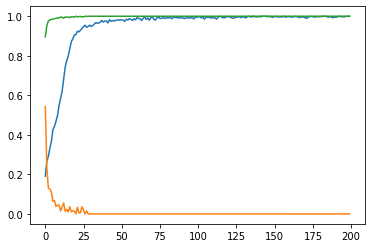

In [ ]:
# train(tf.keras.applications.Xception())

training using inception_v3
face fine tuned
audio fine tuned
Epoch 1/200
144/144 - 1542s - loss: 0.5998 - categorical_accuracy: 0.9062 - val_loss: 2.4321 - val_categorical_accuracy: 0.6528
Epoch 2/200
144/144 - 23s - loss: 0.1936 - categorical_accuracy: 0.9618 - val_loss: 3.7254 - val_categorical_accuracy: 0.6667
Epoch 3/200
144/144 - 22s - loss: 0.1997 - categorical_accuracy: 0.9601 - val_loss: 5.5817 - val_categorical_accuracy: 0.5799
Epoch 4/200
144/144 - 22s - loss: 0.0604 - categorical_accuracy: 0.9852 - val_loss: 6.4317 - val_categorical_accuracy: 0.5694
Epoch 5/200
144/144 - 22s - loss: 0.0940 - categorical_accuracy: 0.9878 - val_loss: 5.6484 - val_categorical_accuracy: 0.6146
Epoch 6/200
144/144 - 22s - loss: 0.1108 - categorical_accuracy: 0.9861 - val_loss: 5.5271 - val_categorical_accuracy: 0.6181
Epoch 7/200
144/144 - 22s - loss: 0.0720 - categorical_accuracy: 0.9844 - val_loss: 6.9673 - val_categorical_accuracy: 0.5833
Epoch 8/200
144/144 - 22s - loss: 0.1138 - categorical_

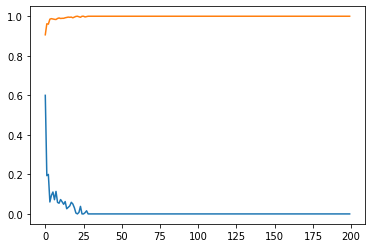

In [ ]:
# train(tf.keras.applications.InceptionV3())

225214464/225209952 [==============================] - 1s 0us/step
training using inception_resnet_v2
face fine tuned
Epoch 1/200
144/144 - 408s - loss: 1.9592 - categorical_accuracy: 0.3099 - val_loss: 2.6066 - val_categorical_accuracy: 0.1562
Epoch 2/200
144/144 - 28s - loss: 1.6321 - categorical_accuracy: 0.4019 - val_loss: 2.5279 - val_categorical_accuracy: 0.2326
Epoch 3/200
144/144 - 28s - loss: 1.4051 - categorical_accuracy: 0.5052 - val_loss: 73.5873 - val_categorical_accuracy: 0.1458
Epoch 4/200
144/144 - 28s - loss: 1.2426 - categorical_accuracy: 0.5486 - val_loss: 8.4204 - val_categorical_accuracy: 0.2500
Epoch 5/200
144/144 - 28s - loss: 1.0163 - categorical_accuracy: 0.6389 - val_loss: 22.8735 - val_categorical_accuracy: 0.2396
Epoch 6/200
144/144 - 28s - loss: 0.8032 - categorical_accuracy: 0.7231 - val_loss: 2.3383 - val_categorical_accuracy: 0.4201
Epoch 7/200
144/144 - 28s - loss: 0.5339 - categorical_accuracy: 0.8082 - val_loss: 3.5432 - val_categorical_accuracy: 0.45

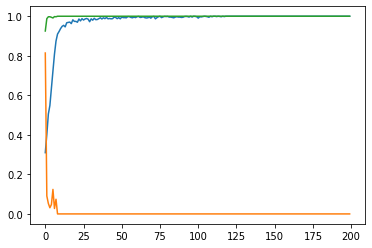

In [13]:
# train(tf.keras.applications.InceptionResNetV2())

In [ ]:
train(tf.keras.applications.ResNet50())